# Download data

In [3]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [4]:
import numpy as np
import pandas as pd
import polars as pl
import joblib

In [5]:
train_data = pd.read_parquet("data/train_data.parquet")

In [6]:
train_data.shape

(11774752, 101)

In [7]:
val_data = pd.read_parquet("data/validate_data.parquet")

In [8]:
val_data.shape

(639848, 101)

## Data cleaning

In [9]:
# feature selection ## select every feature except 0-4 
# feature_cols = ["symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]

#select target values
target_cols = ["responder_6"]

# select the weight values
weight_cols = ["weight"]

## drop the other responder column

In [10]:
from sklearn.preprocessing import MinMaxScaler

ScaleX =    joblib.load("model/XGBoost_scaleX.pkl")
ScaleY =    joblib.load("model/XGBoost_scaleY.pkl")

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
# the chunk requir maximum memory
X_train =   ScaleX.transform(train_data[feature_cols])
y_train =   ScaleY.transform(train_data[target_cols])
w_train =   train_data[weight_cols]
X_val =     ScaleX.transform(val_data[feature_cols])    
y_val =     val_data[target_cols]
w_val =     val_data[weight_cols]

In [12]:
y_train.min(), y_train.max()

(-1.0, 1.0)

In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [14]:
# Sample a subset of the data
sample_fraction = 1000  # Adjust this fraction as needed
i = 5054
X_train_sampled = X_train[sample_fraction*i:sample_fraction*(i+1)]
y_train_sampled = y_train[sample_fraction*i:sample_fraction*(i+1)]
w_train_sampled = w_train[sample_fraction*i:sample_fraction*(i+1)]
X_train_sampled.shape, y_train_sampled.shape, w_train_sampled.shape

((1000, 88), (1000, 1), (1000, 1))

In [15]:
# state the search
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8 , 9, 10, 11],
    'n_estimators': [100, 200, 300, 500, 1000],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.01, 0.1, 1, 10, 100],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
}

#define the model
model  = XGBRegressor(random_state = 42 , device = 'cuda')

# define grid_search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1000, cv=5, scoring='r2', verbose=1, n_jobs=-1, random_state=42)

# do the grid search
random_search.fit(X_train_sampled, y_train_sampled, sample_weight = w_train_sampled)

# Get the best parameters and evaluate the model
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


In [16]:
# Create the XGBRegressor model with the specified parameters
model = XGBRegressor(**best_params, random_state = 42 , device = 'cuda')

# Fit the model to the training data
model.fit(X_train, y_train,sample_weight=w_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
pred = model.predict(X_val)
pred_inverse = ScaleY.inverse_transform(pred.reshape(-1, 1))
r2 = r2_score(y_val, pred_inverse, sample_weight=w_val)
print(f"R2 score: {r2:.6f}")

c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


R2 score: 0.005771


In [18]:
pred_inverse.min(), pred_inverse.max()

(-1.743548, 4.986042)

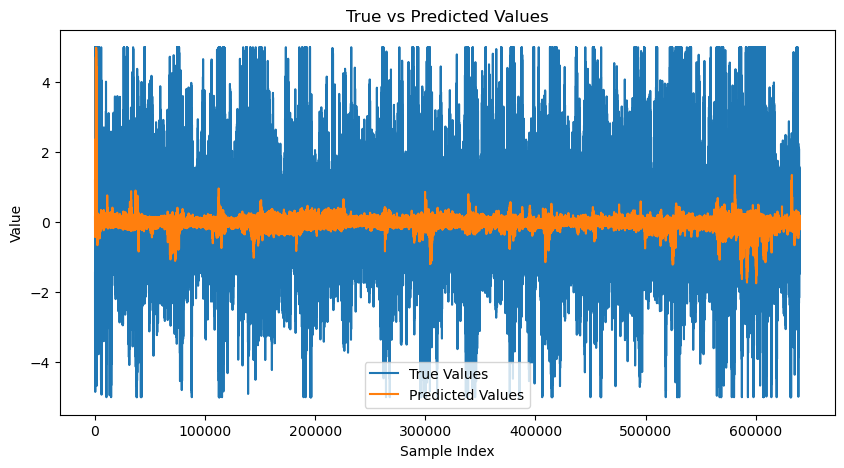

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(pred_inverse, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [20]:
def validate_n_fold(model,X_val, y_val,w_val, n_folds):
    global ScaleY
    batch_size = len(y_val)//n_folds    
    for i in range(0, len(X_val), batch_size):
        X_batch = X_val[i:i+batch_size]
        y_batch = y_val[i:i+batch_size]
        w_batch = w_val[i:i+batch_size]
        preds = model.predict(X_batch)
        pred_inverse = ScaleY.inverse_transform(preds.reshape(-1, 1))
        score1 = r2_score(y_batch, pred_inverse ,sample_weight= w_batch)
        print(f'Batch {i//batch_size} r2_score: {score1:.6f}')

In [21]:
validate_n_fold(model,X_val, y_val, w_val, 10)

Batch 0 r2_score: 0.020097
Batch 1 r2_score: 0.003915
Batch 2 r2_score: 0.002096
Batch 3 r2_score: 0.010696
Batch 4 r2_score: -0.001736
Batch 5 r2_score: 0.004642
Batch 6 r2_score: 0.006354
Batch 7 r2_score: 0.003450
Batch 8 r2_score: 0.005465
Batch 9 r2_score: 0.000751
Batch 10 r2_score: -1.074611


# save data

In [22]:
import joblib
# save
joblib.dump(model, "model/XGBoost_test8.pkl") 

['model/XGBoost_test8.pkl']